In [3]:
import pandas as pd

cr_loan = pd.read_csv('/content/cr_loan_nout_nmiss.csv.csv')

In [4]:
#removing outliers
indices = cr_loan[cr_loan['person_emp_length'] >= 60].index
cr_loan.drop(indices, inplace=True)

In [5]:
#Find Missing data
null_columns = cr_loan.columns[cr_loan.isnull().any()]
cr_loan[null_columns].isnull().sum()

Series([], dtype: float64)

In [6]:
#Replace Missing data with median
cr_loan['loan_int_rate'].fillna((cr_loan['loan_int_rate'].mean()), inplace = True)


In [7]:
#Drop missing data
indices = cr_loan[cr_loan['person_emp_length'].isnull()].index
cr_loan.drop(indices, inplace=True)


In [8]:
cr_loan_clean = pd.read_csv('/content/cr_loan_nout_nmiss.csv.csv')

In [9]:
# Separate the numeric columns
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
# Separate non-numeric columns
cred_cat = cr_loan_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns only
cred_cat_onehot = pd.get_dummies(cred_cat)
# Union the numeric columns with the one-hot encoded column
cr_loan_clean = pd.concat([cred_num, cred_cat_onehot], axis=1)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Create the X and y data sets
X = cr_loan_clean.drop(['loan_status', 'person_home_ownership_OWN'], axis = 1)
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [19]:
X.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

In [20]:
# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression(solver='lbfgs')
clf_logistic_single.fit(X, np.ravel(y))

LogisticRegression()

In [23]:
# Check the accuracy against the test data
clf_logistic_single.score(X_test,y_test)



0.8026137135098439

In [24]:
# Print the parameters of the model
print(clf_logistic_single.get_params())

# Print the intercept of the model
print(clf_logistic_single.intercept_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[-2.17611518e-09]


In [28]:
# Create predictions of probability for loan status using test data
preds = clf_logistic_single.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            1      0.445125
1            1      0.221721
2            0      0.286980
3            0      0.167608
4            1      0.112640


In [29]:
from sklearn.metrics import classification_report
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

# Print the row counts for each loan status
print(preds_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

loan_status
0    11176
1      608
Name: count, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      9198
     Default       0.71      0.17      0.27      2586

    accuracy                           0.80     11784
   macro avg       0.76      0.57      0.58     11784
weighted avg       0.79      0.80      0.75     11784



0.8026137135098439


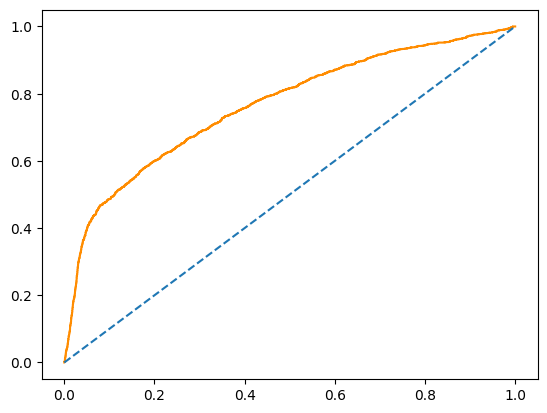

In [31]:
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

# Create predictions and store them in a variable
preds = clf_logistic_single.predict_proba(X_test)

# Print the accuracy score the model
print(clf_logistic_single.score(X_test, y_test))

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = metrics.roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)

In [32]:
from sklearn.metrics import confusion_matrix
# Set the threshold for defaults to 0.5
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test,preds_df['loan_status']))

[[9024  174]
 [2152  434]]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

NameError: name 'avg_loan_amnt' is not defined

In [33]:
import xgboost as xgb
# Create a gradient boosted tree model
clf_gbt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 4)
#learning rate: smaller makes more conservative
#max_depth: how deep each tree can go, making more complex




In [34]:
# Train the model
clf_gbt.fit(X_train,np.ravel(y_train))
# Print the feature importances
clf_gbt.get_booster().get_score(importance_type = 'weight')

{'person_age': 87.0,
 'person_income': 281.0,
 'person_emp_length': 93.0,
 'loan_amnt': 102.0,
 'loan_int_rate': 148.0,
 'loan_percent_income': 132.0,
 'cb_person_cred_hist_length': 35.0,
 'person_home_ownership_MORTGAGE': 22.0,
 'person_home_ownership_OTHER': 10.0,
 'person_home_ownership_RENT': 49.0,
 'loan_intent_DEBTCONSOLIDATION': 27.0,
 'loan_intent_EDUCATION': 17.0,
 'loan_intent_HOMEIMPROVEMENT': 29.0,
 'loan_intent_MEDICAL': 35.0,
 'loan_intent_PERSONAL': 14.0,
 'loan_intent_VENTURE': 24.0,
 'loan_grade_A': 1.0,
 'loan_grade_B': 10.0,
 'loan_grade_C': 31.0,
 'loan_grade_D': 29.0,
 'loan_grade_E': 15.0,
 'loan_grade_F': 9.0,
 'loan_grade_G': 17.0,
 'cb_person_default_on_file_N': 4.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

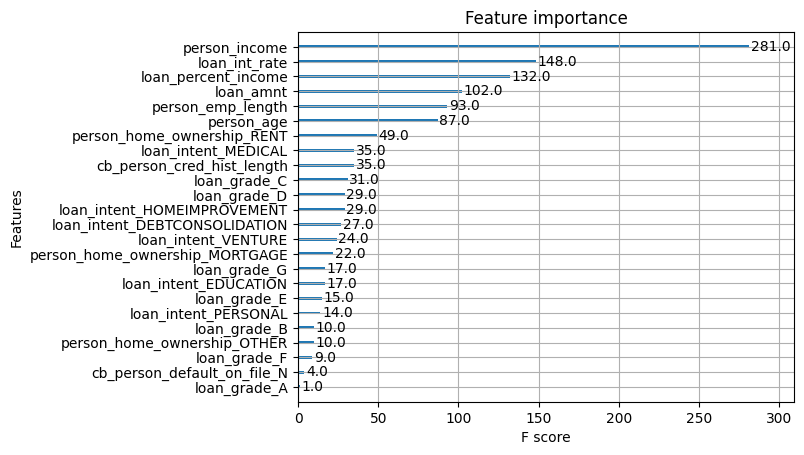

In [35]:
#plotting feature importance
xgb.plot_importance(clf_gbt, importance_type = 'weight')

In [36]:
# Set the number of folds
n_folds = 2
# Set early stopping number
early_stop = 5
# Set any specific parameters for cross validation
params = {'objective': 'binary:logistic','seed': 99, 'eval_metric':'auc'}

In [37]:
# Restructure the train data for xgboost
DTrain = xgb.DMatrix(X_train, label = y_train)
# Perform cross validation
xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds, early_stopping_rounds=early_stop)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.904163,0.001138,0.886037,0.007796
1,0.908559,0.005334,0.894034,0.000144
2,0.914913,0.002881,0.899132,0.001694
3,0.922782,0.000562,0.906345,0.001899
4,0.926911,0.000535,0.909473,0.000649


In [38]:
#cross validation scoring
# Import the module
from sklearn.model_selection import cross_val_score
# Create a gbt model
xg = xgb.XGBClassifier(learning_rate = 0.4, max_depth = 10)
# Use cross valudation and accuracy scores 5 consecutive times
cross_val_score(clf_gbt, X_train, y_train, cv = 5)


array([0.94031117, 0.93465347, 0.92899576, 0.93352192, 0.92107496])

In [39]:
# Concat the training sets
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
# Get the counts of defaults and non-defaults
count_nondefault, count_default = X_y_train['loan_status'].value_counts()
# Separate nondefaults and defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]


In [40]:
# Undersample the non-defaults using sample() in pandas
nondefaults_under = nondefaults.sample(count_default)
# Concat the undersampled non-defaults with the defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True), defaults.reset_index(drop = True)], axis=0)


In [42]:
# Compute the threshold for 85% acceptance rate
threshold = np.quantile(prob_default, 0.85)

In [43]:
#implementing threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1if x > 0.804 else 0)

In [46]:
# Set all the acceptance rates to test
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
# Create lists to store thresholds and bad rates
thresholds = []
bad_rates = []

In [ ]:
for rate in accept_rates:
  # Calculate threshold
  threshold = np.quantile(preds_df['prob_default'], rate).round(3)
  # Store threshold value in a list
  thresholds.append(np.quantile(preds_gbt['prob_default'], rate).round(3))
  # Apply the threshold to reassign loan_status
  test_pred_df['pred_loan_status'] = \
  test_pred_df['prob_default'].apply(lambda x: 1if x > thresh else 0)
  # Create accepted loans set of predicted non-defaults
  accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
  # Calculate and store bad rate
  bad_rates.append(np.sum((accepted_loans['true_loan_status'])
  / accepted_loans['true_loan_status'].count()).round(3))

In [ ]:
#creating a strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates), columns = ['Acceptance Rate','Threshold','Bad Rate'])
